In [43]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt

In [44]:
def calculate_Hausholder(v: np.array):
    """
    Helper function to calculate the Hausholder matrix from v.
    
    Parameters
    ----------
    v : np.array
        The given vector. Needs to be normalized prior to passing.
        
    Returns
    -------
    H : np.ndarray
        The Hausholder matrix of v.
    """
    H = np.identity(max(v.shape)) - 2*np.outer(v, v)
    return H

def recover_Qis(A: np.ndarray):
    """
    Calculates all Q_is from a Hausholder applied matrix A.
    
    Parameters
    ----------
    
    A : np.ndarray
        The matrix on which Hausholder QR has been performed
        
    Returns
    -------
    Qis : list(np.ndarray)
        A list containing all Q's 
    """
    Qis = []
    
    m, n = A.shape
    
    for i in range(n):
        v = A[i+1:, i].copy()
        Q = np.identity(m-1)
        Q[i:, i:] = calculate_Hausholder(v)
        Qis.append(Q)
    
    return Qis

def calculate_Q(A: np.ndarray):
    """
    Returns the orthonormal matrix Q from the matrix A after Hausholder QR 
    is applied.
    
    Parameters
    ----------
    
    A : np.ndarray
        The matrix on which Hausholder QR has been performed

    Returns
    -------    
    
    Q: np.ndarray
        The orthonormal matrix involved in QR
    """
    
    Qis = recover_Qis(A.copy())
    Q = np.identity(Qis[0].shape[0])
    for Qi in Qis:
        Q = np.matmul(Q, Qi.T)
        
    return Q


def haus(a, j, m):
    """
    Calculates the HausHolder Iteration from given vector, index, 
    and size of original matrix 
    """
    v = a / (a[0] + np.copysign(np.linalg.norm(a), a[0]))
    v[0] = 1

    H = np.identity(m)
    H[j:, j:] -= (2 / np.linalg.norm(v, ord=2)**2) * np.outer(v, v)
    return v, H

def qr_decomposition_haus(A: np.ndarray) -> np.array:
    """
    Calcualtes the QR decomposition of the given matrix and 
    returns the HausHolder vectors and R inside the given matrix.
    """
    m,n = A.shape
    
    R = A.copy()
    Q = np.identity(m)
    A = np.vstack((A, np.zeros(A.shape[1])))
    
    for j in range(n):
        # Apply Householder transformation.
        v, H = haus(R[j:, j, np.newaxis], j, m)
        
        R = np.matmul(H, R)
        Q = np.matmul(H, Q)
        
        A[j+1:, j] = v.T
    
    #Replace the Upper triangle of A with R
    indices = np.triu_indices_from(A, k=0)
    A[indices] = R[indices]
    
    return A

def my_qr(A: np.ndarray):
        """
        Returns the QR factorization of a nonsingular array
        via (classical) Gram-Schmidt.

        Parameters
        ----------
        A: np.ndarray
            The matrix with which we find the QR factorization.
            Must be nonsingular, sized n x n

        Returns
        -------
        Q: np.ndarray
            A set of orthonormal column vectors of size n x n

        R: np.ndarray
            An upper triangular matrix
        """
        m, n = A.shape
        Q = np.zeros((m, m))
        R = np.zeros((m, n))

        for i in range(0, n): #Row Iter
            prev = 0 # used to catch r_{jk}q_j in sum
            for j in range(0, i+1): # maintain upper triangularity
                if i != j:
                    R[j, i] = np.dot(Q[:, j], A[:, i])
                    prev += R[j, i] * Q[:, j]
                else: #Diagonal term, take prev
                    R[i, i] = np.linalg.norm(A[:, i] - prev, ord = 2)
                    assert R[i, i] != 0, "Diagonal is zero, function cannot continue"
                    Q[:, j] = (1/R[i, i]) * (A[:, i] - prev)
    
        return (Q, R)

In [45]:
def get_Van_b():
    """
    Gets the Vandermonde matrix and b we are considering.
    
    """
    n = 15
    m = 100

    alphas = np.array([i/(m - 1) for i in range(m)])
    
    Van = np.ndarray((m, n))
    for i in range(m):
        for j in range(n):
            Van[i, j] = alphas[i]**j
    b = np.zeros(m)
    for i in range(m):
        b[i] = math.exp(math.sin(4 * alphas[i]))
        
    return Van, b

In [46]:
Van, b = get_Van_b()

# Full rank Least Squares, part i
This just factors A into A = Q[R 0]. Then the minimum length is Q_2^Tb, where Q_2 is the last m-n columns of Q. x is found by x = R^\inv c, since R is invertible.

In [47]:
def back_substitution(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    n = b.size
    x = np.zeros_like(b)

    if A[n-1, n-1] == 0:
        raise ValueError


    x[n-1] = b[n-1]/A[n-1, n-1]
    C = np.zeros((n,n))
    for i in range(n-2, -1, -1):
        bb = 0
        for j in range (i+1, n):
            bb += A[i, j]*x[j]

        C[i, i] = b[i] - bb
        x[i] = C[i, i]/A[i, i]

    return x

In [49]:

n = 15
m = 100

HH = qr_decomposition_haus(Van)
#HH = np.linalg.qr(Van)

R = np.triu(HH) 

#Take nonzero rows of R. Since Van is full rank, will be n rows
R = np.array([x for x in R if x.any() != 0])
#Check if I did it right
assert R.shape == (n, n), "Oops"

Q = calculate_Q(HH)

#Q = HH[0]
c = np.matmul(HH_Q[:, :n].T, b)
d = np.matmul(HH_Q[:, n:].T, b) #Don't think I need to actually compute this

#Solution to part i 
x_soli = back_substitution(R, c)
x_soli[-1]

-11722843.91526459

In [40]:
x_soli

array([ 4.53481148e+08, -4.94842129e+08, -1.13702968e+09,  4.33877781e+08,
        4.55055022e+08, -1.00792659e+08, -1.14017610e+08,  6.35464716e+07,
       -9.38026240e+06, -3.99858766e+06,  4.76135970e+05,  1.61153929e+05,
       -1.73566559e+04, -2.74580146e+03, -1.17961619e+07])

In [50]:
A = Van
HH = hausholder_qr(A)
Q_GS, R_GS = my_qr(A)
Q_C, R_C = np.linalg.qr(A)
R_HH = np.triu(HH)
R_HH = np.array([x for x in R_HH if x.any() != 0])
Q_HH = calculate_Q(HH)[:, :n]


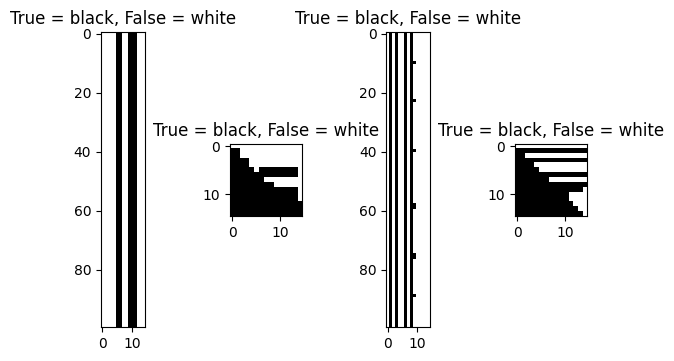

In [51]:
plt_arr1 = abs(Q_C - Q_HH) < 0.0001
plt_arr2 = abs(R_C - R_HH) < 0.0001
plt_arr3 = abs(Q_C - Q_GS[:, :n]) < 0.0001
plt_arr4 = abs(R_C - R_GS[:n, :n]) < 0.0001
plt.subplot(1, 4, 1)
plt.imshow(plt_arr1, cmap='Greys',  interpolation='nearest')
plt.title("True = black, False = white")
plt.subplot(1, 4, 2)
plt.imshow(plt_arr2, cmap='Greys',  interpolation='nearest')
plt.title("True = black, False = white")
plt.subplot(1, 4, 3)
plt.imshow(plt_arr3, cmap='Greys',  interpolation='nearest')
plt.title("True = black, False = white")
plt.subplot(1, 4, 4)
plt.imshow(plt_arr4, cmap='Greys',  interpolation='nearest')
plt.title("True = black, False = white")
plt.tight_layout(pad = 5)

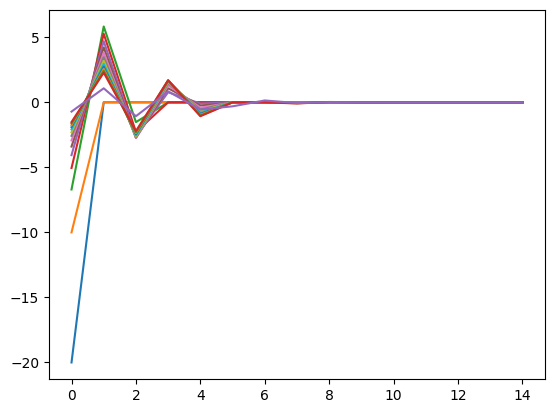

In [52]:
plt.plot(R_C - R_HH)

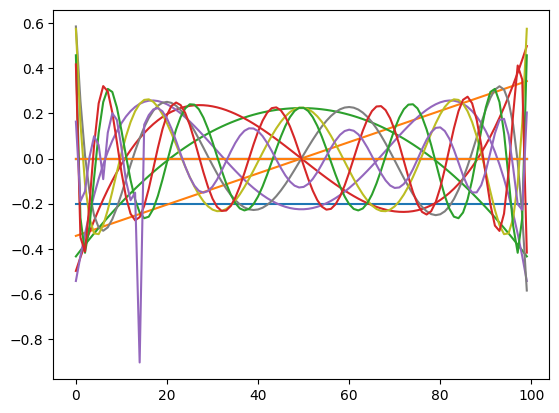

In [53]:
plt.plot(Q_C - Q_HH)